# Titanic at Kaggle 鐵達尼號生存預測(用xgboost)
<img src="https://www.ibm.com/support/knowledgecenter/zh-tw/SS3RA7_sub/modeler_crispdm_ddita/clementine/images/crisp_process.jpg">

In [1]:
#安裝xgboost
! pip install xgboost

## step1 Load data 讀資料

In [2]:
#引入套件
import numpy as np
import pandas as pd
import seaborn as sns #資料視覺化
#設置sns樣式
sns.set(style='white',context='notebook',palette='muted')

#讀訓練集
train=pd.read_csv('train.csv')
#讀測試集
test= pd.read_csv("test.csv")

#觀察欄位
train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
#分別查看實驗數據集和預測數據集數據
print('實驗數據大小:',train.shape)
print('預測數據大小:',test.shape)

實驗數據大小: (891, 12)
預測數據大小: (418, 11)


In [4]:
#觀察DataFrame資訊
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [5]:
train.describe()
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Step 2 : Prepare Data (preprocessing)
* imputation 補齊data(看有沒有缺值,不然維度不對)
* normalize data
* data type conversion 資料轉換(像男生女生是物件,型別不對)
* find useful features 找到有用的特徵

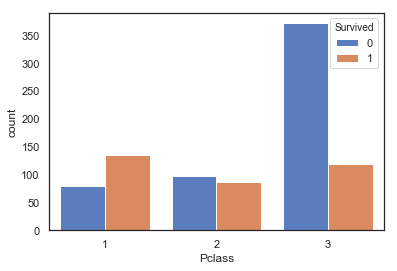

In [6]:
# 我們找有用的特徵值
#feature Pclass艙等
sns.countplot(train['Pclass'],hue=train['Survived'])#(坐1選項頭等艙活的機率比較高)

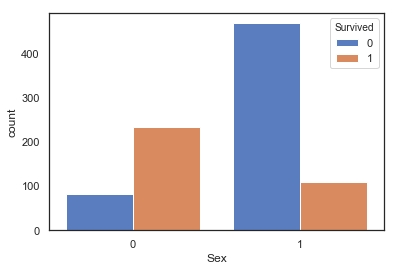

In [7]:
# feature Sex 性別
#並將字串轉成有用的數字
train["Sex"] = train["Sex"].apply(lambda x: 1 if x == "male" else 0)
test["Sex"] = test["Sex"].apply(lambda x: 1 if x == "male" else 0)
sns.countplot(train['Sex'],hue=train['Survived']) #男生跟女生存活比率(女生比較會活著)
#sns.countplot(train['Survived'],hue=train['Sex']) #要相反過來驗證

before imputation=====
S    644
C    168
Q     77
Name: Embarked, dtype: int64
after imputation===
S    646
C    168
Q     77
Name: Embarked, dtype: int64


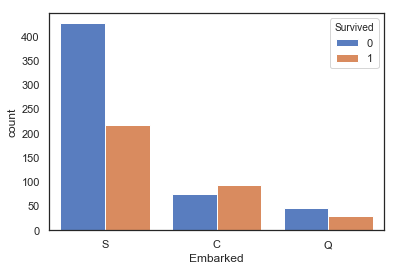

In [8]:
#補空值
# feature Embarked 港口
sns.countplot(train['Embarked'],hue=train['Survived'])#S港口活的比率低

print('before imputation=====')
#print(train[train['Embarked'].isnull()]) # .isnull() #列出是nan的(True的)
print(train['Embarked'].value_counts())#.value_counts()列出不是nan的統計(觀察最多的為S)
#print(train['Embarked'].isnull().value_counts()) # .isnull().value_counts()列出【是否nan】 True false數量(說明有兩個nan)

print('after imputation===')
#補nan值為S(因為S最低)
train['Embarked']=train['Embarked'].fillna('S')
print(train['Embarked'].value_counts()) # S 從644 變 646，補nan成功

#將字串變成有用的數字
def getEmbark(Embarked):
    if Embarked == "S":
        return 1
    elif Embarked == "C":
        return 2
    else:
        return 3

train["Embarked"] = train["Embarked"].apply(getEmbark)
test["Embarked"] = test["Embarked"].apply(getEmbark)



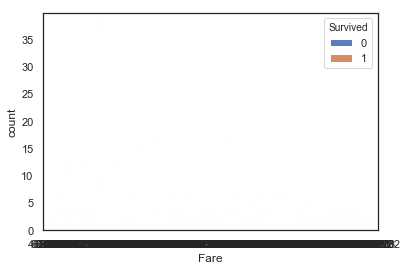

In [9]:
# feature Fare 票價 
sns.countplot(train['Fare'],hue=train['Survived'])

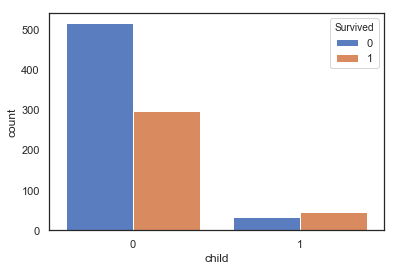

In [10]:
#先補age年齡的nan 
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())
# feature child 定義新特徵小孩 
train["child"] = train["Age"].apply(lambda x: 1 if x < 15 else 0)
test["child"] = test["Age"].apply(lambda x: 1 if x < 15 else 0)
sns.countplot(train['child'],hue=train['Survived'])#小孩生存比較多

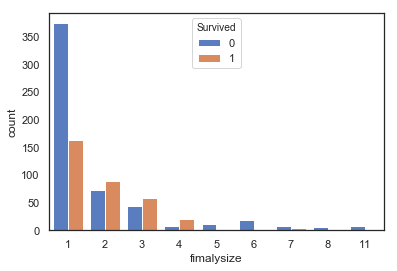

In [11]:
# feature fimalysize 定義新特徵 家庭人數 (兄弟姐妹及配偶的個數+父母或子女的個數+1)
train["fimalysize"] = train["SibSp"] + train["Parch"] + 1
test["fimalysize"] = test["SibSp"] + test["Parch"] + 1
sns.countplot(train['fimalysize'],hue=train['Survived'])#fimalysize 2.3.4 人生存率高

In [14]:
x=train[['Pclass','Sex','Embarked','Fare','child','fimalysize']].values.reshape(-1,6)
y=train['Survived'].values.reshape(-1,1)#變成numpy.ndarray
print(y.shape,type(y))

testx= test[['Pclass','Sex','Embarked','Fare','child','fimalysize']].values.reshape(-1,6)

(891, 1) <class 'numpy.ndarray'>


# Step 3 : Build model 建置模型

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#初始化
clf =XGBClassifier(learning_rate=0.1, max_depth=2, silent=True, objective='binary:logistic')

# 設置boosting迭代計算次數
param_test = {
    'n_estimators': range(30, 50, 2),
    'max_depth': range(2, 7, 1)
}
#交叉驗證
model = GridSearchCV(estimator = clf, param_grid = param_test, scoring='accuracy', cv=5)
model.fit(x, y)

#預測
y_pred = model.predict(testx)

print(y_pred)

test['Survived']=y_pred

C:\Users\u0151051\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0151051\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0151051\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0151051\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


# Step 4: Evaluate Model

In [16]:
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score

#kfold = KFold(n_splits=10, random_state=7)
#results = cross_val_score(model, x, y, cv=kfold)
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


# Step 5 : Write back  test results 寫出檔案

In [17]:
test=test[['PassengerId','Survived']]
test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [18]:
test.to_csv("submit.csv",index=False,mode='w')